In [3]:
import cv2
import json
import treepoem
import numpy as np
import sympy as sp
from pathlib import Path
from matplotlib import pyplot as plt

3.3306690738754696e-16


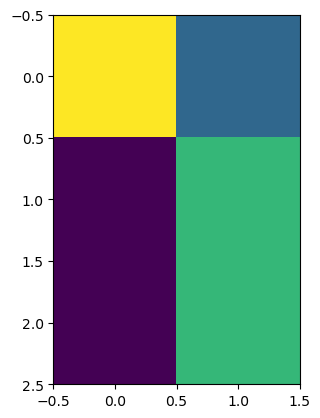

In [73]:
c3d = [
    [0,0,0],
    [0,1,1],
    [1,1,0],
    [1,0,0],
]

c2d = [
    [0, 0],
    [0, 1],
    [0.75, 0.75],
    [0.75, 0.25]
]
A,_, _, _ = np.linalg.lstsq(c3d, c2d, rcond=-1)
print(np.abs(c3d@A - c2d).max())
# plt.scatter(*(c3d@A).T)
plt.imshow(A)
# A

In [74]:
A

array([[ 7.50000000e-01,  2.50000000e-01],
       [ 0.00000000e+00,  5.00000000e-01],
       [-3.92523115e-17,  5.00000000e-01]])